In [1]:
from src.datasets import patientDataset, eegDataset
from src.resnet import ResNet1d
from tqdm import tqdm
import numpy as np

In [2]:
import torch
from torch.utils.data import DataLoader

pattrainset = patientDataset("../train/")
trainset = eegDataset(pattrainset, [i for i in range(len(pattrainset))])
trainloader = DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=20)

pattestset = patientDataset("../split_1/")
testset = eegDataset(pattestset, [i for i in range(len(pattestset))])
testloader = DataLoader(dataset=testset, batch_size=128, shuffle=True, num_workers=20)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:26<00:00,  4.62it/s]


In [3]:
def validate(model, val_loader, criterion):
    val_loss = []
    model.eval()
    for i, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels = labels.type(torch.FloatTensor).reshape((labels.shape[0],1)).to(device)
        
        outputs = model(inputs)
        loss    = criterion(outputs, labels)
        val_loss.append(loss.item())
    
    return np.mean(val_loss)

In [4]:
def train_one_epoch(model, optimizer, criterion ,train_loader, epoch):
    model.train()
    train_loss = []
    for i, (inputs, labels) in enumerate(train_loader): 
            
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels = labels.type(torch.FloatTensor).reshape((labels.shape[0],1)).to(device)
        
        outputs = model(inputs)
        loss    = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.cpu().detach().numpy())
        print("Epoch {}: {}/{} Loss: {}".format(epoch, i, len(train_loader), loss.item()), end='\r')
    return np.mean(train_loss)

In [7]:
train_config = { 'num_epochs':10, 'learning_rate':1e-5 }
arch_config  = {
                'n_input_channels':18,
                'signal_length':1200,
                'net_filter_size':[ 18, 36, 24, 18],
                'net_signal_length':[ 600, 200, 100, 50],
                'kernel_size': 9,
                'n_classes':2,
                'dropout_rate':0.5
               }

model = ResNet1d(input_dim=(arch_config['n_input_channels'], arch_config['signal_length']), 
                 blocks_dim=list(zip(arch_config['net_filter_size'], arch_config['net_signal_length'])),
                 kernel_size=arch_config['kernel_size'],
                 dropout_rate=arch_config['dropout_rate'])
model = model.to(device)

criterion = torch.nn.BCELoss(reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=train_config['learning_rate'], weight_decay=1e-7)

In [8]:
train_losses = []
val_losses = []

for epoch in range(train_config['num_epochs']):
    train_losses.append(train_one_epoch(model, optimizer, criterion, trainloader, epoch))
    val_losses.append(validate(model, testloader, criterion))
                        

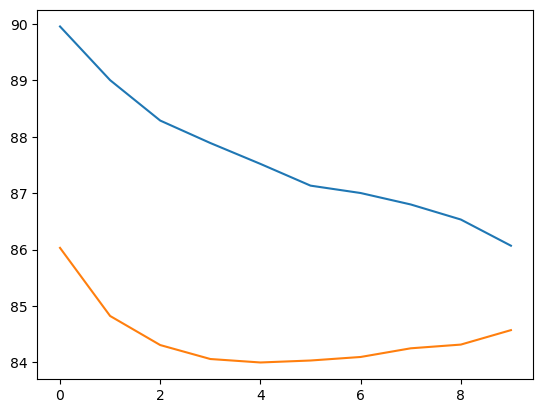

In [9]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)